In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy.stats import truncnorm
from tqdm import tqdm

import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math
import sys
import os

sys.path.insert(0, '..')

from functions.adjust_cases_functions import prepare_cases, smooth_1d

In [2]:
# read population
pop        = 49263774.0


# read cases by age without filtering
# previously group them in the ages of interest.
cases_df = pd.read_csv(os.path.join('../data/Datos.csv'), delimiter=";", parse_dates=["Dates"]).set_index('Dates')
cases_df = prepare_cases(cases_df, col='InfectadosNoVacunados')
cases_df = prepare_cases(cases_df, col='InfectadosPrimeraDosis')
cases_df = prepare_cases(cases_df, col='InfectadosEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='InfectadosDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='InfectadosVacunados')
cases_df = prepare_cases(cases_df, col='InfectadosTotal')
cases_df = prepare_cases(cases_df, col='HospitalizadosNoVacunados')
cases_df = prepare_cases(cases_df, col='HospitalizadosPrimeraDosis')
cases_df = prepare_cases(cases_df, col='HospitalizadosEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='HospitalizadosDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='HospitalizadosVacunados')
cases_df = prepare_cases(cases_df, col='HospitalizadosTotal')
cases_df = prepare_cases(cases_df, col='MuertesNoVacunados')
cases_df = prepare_cases(cases_df, col='MuertesPrimeraDosis')
cases_df = prepare_cases(cases_df, col='MuertesEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='MuertesDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='MuertosVacunados')
cases_df = prepare_cases(cases_df, col='MuertesTotal')
cases_df

,InfectadosNoVacunados,InfectadosPrimeraDosis,InfectadosEsquemaCompleto,InfectadosDosisRefuerzo,InfectadosVacunados,InfectadosTotal,HospitalizadosNoVacunados,HospitalizadosPrimeraDosis,HospitalizadosEsquemaCompleto,HospitalizadosDosisRefuerzo,...,smoothed_HospitalizadosEsquemaCompleto,smoothed_HospitalizadosDosisRefuerzo,smoothed_HospitalizadosVacunados,smoothed_HospitalizadosTotal,smoothed_MuertesNoVacunados,smoothed_MuertesPrimeraDosis,smoothed_MuertesEsquemaCompleto,smoothed_MuertesDosisRefuerzo,smoothed_MuertosVacunados,smoothed_MuertesTotal
Dates,,,,,,,,,,,,,,,,,,,,,
2020-03-06,1,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,2,0,0,0,0,2,1,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-11,6,0,0,0,0,6,3,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-12,4,0,0,0,0,4,3,0,0,0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-13,5,0,0,0,0,5,3,0,0,0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,1674,0,0,0,0,1674,0,0,0,0,...,0.0,0.0,0.0,0.0,52.0,1.0,5.0,0.0,6.0,58.0
2021-11-04,1862,0,0,0,0,1862,0,0,0,0,...,0.0,0.0,0.0,0.0,52.0,1.0,2.0,0.0,3.0,55.0
2021-11-05,1760,0,0,0,0,1760,0,0,0,0,...,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,53.0


In [3]:
from scipy.interpolate import UnivariateSpline
IFR_Verity = [ .00161, .00695, .0309, .0844, .161, .595, 1.93, 4.28, 7.80 ]
ifr_log    = np.log(IFR_Verity)

IFR = np.zeros((80))

ages_fit   = [9, 19, 29, 39, 49, 59, 69, 79, 89]
ifr_fitted = UnivariateSpline(ages_fit, ifr_log)

x = np.arange(0, 90, 1)
fitted_ifr = ifr_fitted(x)

ages_models = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
# Create IFR every 5 years
ifr = np.exp([fitted_ifr[0:6].mean(),fitted_ifr[6:11].mean(),fitted_ifr[11:16].mean(),fitted_ifr[16:21].mean(),
       fitted_ifr[21:26].mean(),fitted_ifr[27:31].mean(),fitted_ifr[31:36].mean(),fitted_ifr[37:41].mean(),
       fitted_ifr[41:46].mean(),fitted_ifr[47:51].mean(),fitted_ifr[51:56].mean(),fitted_ifr[56:61].mean(),
       fitted_ifr[61:66].mean(),fitted_ifr[67:71].mean(),fitted_ifr[71:76].mean(),fitted_ifr[76:].mean()])/100 #%

ifr_m = np.mean(ifr)
ifr_m

0.007005371509405023

In [4]:
def crosscorr(series1, series2, lag=0):
    """ Lag-N cross correlation.
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return series2.corr(series1.shift(lag))
def compute_correlation(series2, series1, lags = list(range(20)), start_day='01-04-2020', final_day=None):
    if not start_day:
        start_day = min(series1.index.values[0], series2.index.values[0])
    if not final_day:
        final_day = min(series1.index.values[-1], series2.index.values[-1])
    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)
    series1 = series1.loc[start_day:max_date]
    series2 = series2.loc[start_day:max_date]
    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')
    for idx, lag in enumerate(lags):
        corr_df.loc[ lag ]['value'] = crosscorr(series1, series2, lag=lag)
    return corr_df

In [5]:
lag = np.argmax(compute_correlation(cases_df['smoothed_MuertesNoVacunados'][:344], cases_df['smoothed_HospitalizadosNoVacunados'][:344]))
lag

10

In [6]:
rates = cases_df.copy()
rates['lag_MuertesNoVacunados'] = 0
rates['lag_MuertesNoVacunados'].iloc[:344]=rates['smoothed_MuertesNoVacunados'].iloc[10:354]
rates = rates.resample('W-Sun').sum()
hfr = np.mean(rates['lag_MuertesNoVacunados'].iloc[:50]/rates['smoothed_HospitalizadosNoVacunados'].iloc[:50])

C:\Users\Windows\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
hfr_t = rates['lag_MuertesNoVacunados'].iloc[:50]/rates['smoothed_HospitalizadosNoVacunados'].iloc[:50]
ifr_t = ifr_m/hfr_t

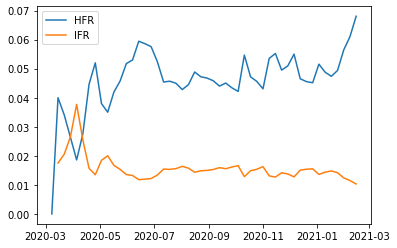

In [8]:
plt.plot(hfr_t/10, label='HFR')
plt.plot(ifr_t, label='IFR')
plt.legend(loc='best')


In [8]:
ihr = ifr_m/hfr
ihr

0.015246691373368334

In [9]:
hfr

0.45946830940917643

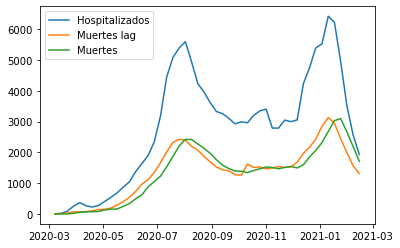

In [11]:
plt.plot(rates['smoothed_HospitalizadosNoVacunados'][:50], label='Hospitalizados')
plt.plot(rates['lag_MuertesNoVacunados'][:50], label='Muertes lag')
plt.plot(rates['smoothed_MuertesNoVacunados'][:50], label='Muertes')
plt.legend()

In [10]:
from models_pompP import model, init_model

param_prior_dict  = {}
param_prior_dict["beta"]  = [0.8, 1.5]        # Contact rate range
# param_prior_dict["ifr"]   = [0.005/100, 2/100] # IFR range         [0.005% - 2%]
param_prior_dict["alpha"] = [0.01, 1]         # Report rate range [1% - 100%]

date_init  = pd.to_datetime("2020-03-06")
date_end   = pd.to_datetime("2021-02-14")

# dates_week = pd.date_range(start=date_init, end=date_end, freq='1D')
# dates      = pd.date_range(start=date_init, end=dates_week[-1], freq='1D')

# num_steps = len(dates_week)

lambda_inf    = 1.1
num_params    = 2
num_iters_mif = 450
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 200
N = pop
num_state_vars   = 9
num_observations = 3
num_iters_save   = 7
num_save_iters   = int(num_iters_mif/num_iters_save)

bog_cases_df = cases_df.reset_index()
obs_df       = bog_cases_df
obs_df       = obs_df.set_index("Dates")
obs_df       = obs_df.loc[date_init:date_end]

# obs_w_df             = obs_df.resample('W-Sun').sum()

oev_df                     = pd.DataFrame(columns=["Dates", "OEV_confirmed", "OEV_deaths"])
oev_df["Dates"]            = obs_df.index.values
oev_df                     = oev_df.set_index("Dates")
oev_df["OEV_confirmed"]    = np.maximum(1e-4, obs_df["smoothed_InfectadosNoVacunados"].values**2/100 )
oev_df["OEV_hospitalized"] = np.maximum(1e-4, obs_df["smoothed_HospitalizadosNoVacunados"].values**2/100 )
oev_df["OEV_deaths"]       = np.maximum(25, obs_df["smoothed_MuertesNoVacunados"].values**2/100 )

dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation
num_steps = len(dates)

######## INFERENCE  SETTINGS ########
# Range of parameters
param_range = np.array([v for k, v in param_prior_dict.items()])
std_param   = param_range[:,1]-param_range[:,0]
SIG         = std_param ** 2 / 4; #  initial covariance of parameters

num_steps     = len(obs_df) #387
para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
theta         = np.zeros((num_params, num_iters_mif+1))

obs_post_all = np.zeros((num_observations, num_ensembles, num_steps, num_iters_save))

para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all    = np.zeros((num_state_vars, num_ensembles, num_steps, num_iters_save))
theta         = np.zeros((num_params, num_iters_mif+1))
para_post_all  = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
################################################

In [15]:
len(dates)

344

Text(0, 0.5, 'Hospitalized')

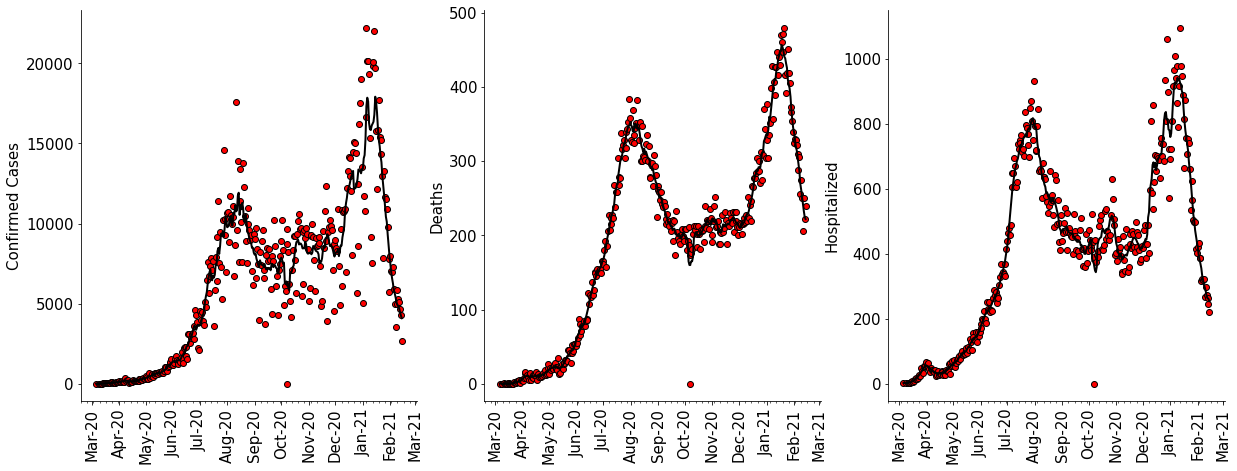

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20.5, 7.2), sharex=True)

ax[0].scatter(obs_df.index.values, obs_df["InfectadosNoVacunados"], edgecolor="k", facecolor="red")
ax[0].plot(obs_df.index.values, obs_df["smoothed_InfectadosNoVacunados"], color="k", lw=2)

ax[1].scatter(obs_df.index.values, obs_df["MuertesNoVacunados"], edgecolor="k", facecolor="red")
ax[1].plot(obs_df.index.values, obs_df["smoothed_MuertesNoVacunados"], color="k", lw=2)

ax[2].scatter(obs_df.index.values, obs_df["HospitalizadosNoVacunados"], edgecolor="k", facecolor="red")
ax[2].plot(obs_df.index.values, obs_df["smoothed_HospitalizadosNoVacunados"], color="k", lw=2)


for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', rotation=90, labelsize=15)

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
ax[0].set_ylabel("Confirmed Cases", fontsize=15)
ax[1].set_ylabel("Deaths", fontsize=15)
ax[2].set_ylabel("Hospitalized", fontsize=15)

In [12]:
from scipy.stats import truncnorm
import numpy as np


def eakf_step_multi_obs(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_obs=6, num_var=9, num_ensembles=200):
    prior_mean_ct = obs_ens_time.mean(-1, keepdims=True) # Average over ensemble member
    prior_var_ct  = obs_ens_time.var(-1, keepdims=True)  # Compute variance over ensemble members
    idx_degenerate = np.where(prior_mean_ct==0)[0]
    prior_var_ct[idx_degenerate] =  1e-3
    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time
    
    # adjust parameters
    rr = np.full((len(dict_params_range) , num_obs), np.nan)
    dx = np.full((len(dict_params_range) , obs_ens_time.shape[-1], num_obs), np.nan)
    for idx_obs in range(num_obs):
        for idx_p, p in enumerate(dict_params_range.keys()):
            A = np.cov(params_prior[idx_p,:], obs_ens_time[idx_obs,:])
            rr[idx_p, idx_obs] =  A[1,0] / prior_var_ct[idx_obs]
            
        dx[:, :, idx_obs] =  np.dot( np.expand_dims(rr[:, idx_obs],-1), np.expand_dims(dy[idx_obs,:], 0) )
        
    mean_rr = rr.mean(-1) # Average over observation space
    mean_dy = dy.mean(0)  # Average over observation space
    mean_dx = dx.mean(-1)
    
    param_post = params_prior + mean_dx
    # adjust variables
    rr = np.full((num_var, num_obs), np.nan)
    dx = np.full((num_var, obs_ens_time.shape[-1], num_obs), np.nan)
    for idx_obs in range(num_obs):
        for idx_var in range(num_var):
            A = np.cov(x_prior[idx_var,:], obs_ens_time[idx_obs,:])
            rr[idx_var, idx_obs] =  A[1,0] / prior_var_ct[idx_obs]
        dx[:, :, idx_obs] =  np.dot( np.expand_dims(rr[:, idx_obs],-1), np.expand_dims(dy[idx_obs,:], 0) )
    mean_dx = dx.mean(-1)
    
    x_post   = x_prior + mean_dx
    obs_post   = obs_ens_time + mean_dy
    return x_post, param_post, obs_post



def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

#     idx_degenerate = np.where(prior_mean_ct==0)[0]
#     prior_var_ct[idx_degenerate] =  1e-3
    if prior_mean_ct==0:
        prior_var_ct =  1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time
#     print(dy.shape)
    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
#     print(np.expand_dims(rr,-1).shape)
#     print(np.expand_dims(dy, 0).shape)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
#     print(dx.shape)
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def eakf_step_prom(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct==0:
        prior_var_ct =  1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time
#     print(dy.shape)
    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
#     print(np.expand_dims(rr,-1).shape)
#     print(np.expand_dims(dy, 0).shape)
    dx_p         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
#     print(dx.shape)
#     param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx_v       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
#     x_post   = x_prior + dx

#     obs_post    = obs_ens_time + dy

    return dx_v, dx_p, dy

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

In [13]:
import time

print(f"Running MIF  \n")

cont = 0
cont1 = 0
for n in tqdm(range(num_iters_mif)): 
    if (n%num_save_iters)==0:
        obs_post_save = np.zeros((num_observations, num_ensembles, num_steps, num_save_iters))
        x_post_save = np.zeros((num_state_vars, num_ensembles, num_steps, num_save_iters))
        cont1 = 0
#         print('update cont1', cont1)
    if n==0:
        # One beta
        p_prior     = sample_params_uniform(param_prior_dict, num_ensembles=num_ensembles)
        theta[:, n] = np.mean(p_prior, -1)
        
        x           = init_model(N,num_ensembles=num_ensembles,num_variables= num_state_vars)

    else:
        params_mean = theta[:,n]
        params_var  = SIG * (alpha_mif**n)**2
        p_prior     = sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=num_ensembles)

        x           = init_model(N,num_ensembles=num_ensembles,num_variables= num_state_vars)

    param_post_time   = np.zeros((num_params, num_ensembles, num_steps))
    x_post_time       = np.zeros((num_state_vars, num_ensembles, num_steps))

    obs_post_time   = np.zeros((num_observations, num_ensembles, num_steps))

    idx_date_update = 0

    confirmed_t    = np.zeros((num_ensembles, 1))
    hospitalized_t = np.zeros((num_ensembles, 1))
    deaths_t       = np.zeros((num_ensembles, 1))

    st = time.time()
    for idx_t, date in enumerate(dates):

#         x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_ensembles)
#         x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=num_params, num_ensembles=num_ensembles)

#         p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf, num_ensembles=num_ensembles)
#         p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=num_ensembles)

#         x_ens =[]

#         for idx_ens in range(num_ensembles):

#             beta        = p_prior[0, idx_ens]
#             alpha       = p_prior[1, idx_ens]
#             x_ens.append(model(x[:,idx_ens], beta, ihr, hfr, alpha, N))

#         x_ens = np.array(x_ens).T
#         x     = x_ens

        beta        = p_prior[0, :]
        alpha       = p_prior[1, :]
        x_ens = model(x, beta, ihr, hfr, alpha, N)
        x     = x_ens

        hospitalized_t +=  np.expand_dims(x_ens[-3,:], -1)
        confirmed_t    +=  np.expand_dims(x_ens[-2,:], -1)
        deaths_t       +=  np.expand_dims(x_ens[-1,:], -1)

        # correct using daily observations
        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):
            
                x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_ensembles)
                x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=num_params, num_ensembles=num_ensembles)

                p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf, num_ensembles=num_ensembles)
                p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=num_ensembles)
            
                param_post = p_prior.copy()
                # Update parameters using confirmed cases
                x_prior = x.copy()
                
                oev_deaths_time = oev_df.loc[date]["OEV_deaths"]

                deaths_time = obs_df.loc[date]["smoothed_MuertesNoVacunados"]

                # Update parameters using confirmed deaths
                x_post, param_post, deaths_obs_post = eakf_step(x, param_post, np.squeeze(deaths_t), deaths_time, oev_deaths_time, param_prior_dict, num_var= num_state_vars)

                x_post                                 = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params= num_state_vars, num_ensembles= num_ensembles)
                param_post                             = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles= num_ensembles)

                # Since the age groups are an index, the arrangement of the age groups remains.
                oev_hospitalized_time = oev_df.loc[date]["OEV_hospitalized"]

                hospitalized_time = obs_df.loc[date]["smoothed_HospitalizadosNoVacunados"]

                # Update parameters using confirmed hospitalized
                x_post, param_post, hospitalized_obs_post = eakf_step(x_post, param_post, np.squeeze(hospitalized_t), hospitalized_time, oev_hospitalized_time, param_prior_dict, num_var= num_state_vars)

                x_post                                 = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params= num_state_vars, num_ensembles= num_ensembles)
                param_post                             = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles= num_ensembles)
                
                oev_confirmed_time = oev_df.loc[date]["OEV_confirmed"]

                confirmed_time = obs_df.loc[date]["smoothed_InfectadosNoVacunados"]

                
                x_post, param_post, confirmed_obs_post = eakf_step(x_post, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, param_prior_dict, num_var=num_state_vars)

                x_post     = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=num_state_vars, num_ensembles=num_ensembles)
                param_post = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles=num_ensembles)
                
                x = x_post.copy()

                # Use posterior and next prior
                p_prior = param_post.copy()

                obs_post_time[0,:,idx_date_update]    = confirmed_obs_post
                obs_post_time[1,:,idx_date_update]    = deaths_obs_post
                obs_post_time[2,:,idx_date_update]    = hospitalized_obs_post
                param_post_time[:,:,idx_date_update]  = param_post
                x_post_time[:,:,idx_date_update]      = x_post

                idx_date_update += 1

                confirmed_t    = np.zeros((num_ensembles, 1))
                hospitalized_t = np.zeros((num_ensembles, 1))
                deaths_t       = np.zeros((num_ensembles, 1))


    et = time.time()
    
    x_post_save[:,:,:,cont1]   = x_post_time                                                     
    obs_post_save[:,:,:,cont1] = obs_post_time
    para_post_all[:,:,:,n] = param_post_time
    cont1 += 1
    if (n+1)%num_save_iters == 0 and n != 0:
        obs_post_all[:,:,:,cont] = obs_post_save.mean(-1)
        print(obs_post_save.mean())
        x_post_all[:,:,:,cont]       = x_post_save.mean(-1)
        cont += 1
        np.savez_compressed('../results/samples_agg_inf_serie_{}.npz'.format(n+1),
                                param_posterior     = para_post_all,
                                x_posterior         = x_post_all,
                                obs_posterior       = obs_post_all,)

    theta[:,n+1] = param_post_time.mean(-1).mean(-1)



Running MIF  



 14%|███████████▎                                                                     | 63/450 [01:48<11:06,  1.72s/it]

2334.0723059184065


 28%|██████████████████████▌                                                         | 127/450 [03:42<09:16,  1.72s/it]

2349.2698677234694


 42%|█████████████████████████████████▉                                              | 191/450 [05:39<07:29,  1.74s/it]

2418.646427795285


 57%|█████████████████████████████████████████████▎                                  | 255/450 [07:40<05:35,  1.72s/it]

2456.44216939529


 71%|████████████████████████████████████████████████████████▋                       | 319/450 [09:46<03:49,  1.75s/it]

2454.7155803476376


 85%|████████████████████████████████████████████████████████████████████            | 383/450 [11:54<01:56,  1.74s/it]

2455.690076027652


 99%|███████████████████████████████████████████████████████████████████████████████▍| 447/450 [14:03<00:05,  1.76s/it]

2453.63963416748


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [14:26<00:00,  1.92s/it]


In [14]:
def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

In [15]:
param_time = np.mean(para_post_all, -1)

df_beta  = create_df_response(param_time[0,:,:], time=num_steps, dates =dates_assimilation)
df_alpha = create_df_response(param_time[1,:,:], time=num_steps, dates =dates_assimilation)

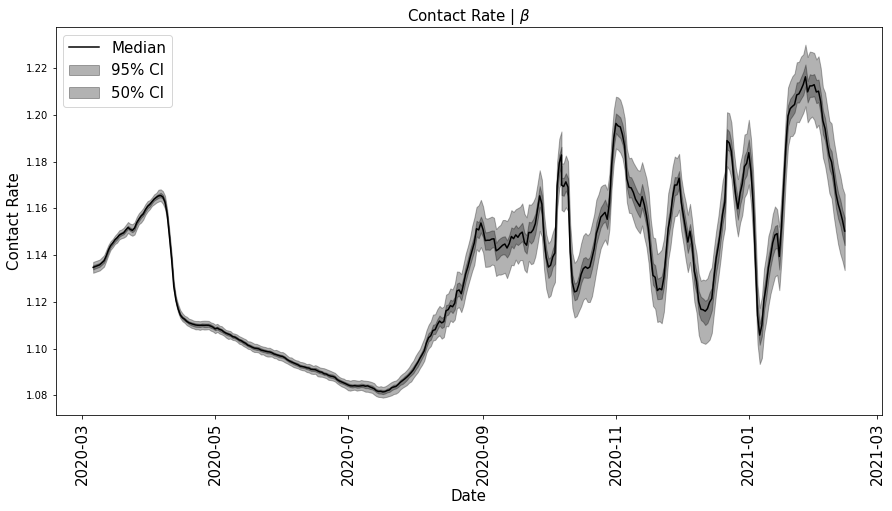

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(df_beta.index.values, df_beta["median"], color='k', label='Median')
ax.fill_between(df_beta.index.values, df_beta["high_95"], df_beta["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_beta.index.values, df_beta["high_50"], df_beta["low_50"], color='k', alpha=0.3, label='50% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Contact Rate", fontsize=15)
ax.set_title(r"Contact Rate | $\beta$ ", fontsize=15)
ax.legend(fontsize=15, loc='best')
plt.tight_layout()
plt.show()


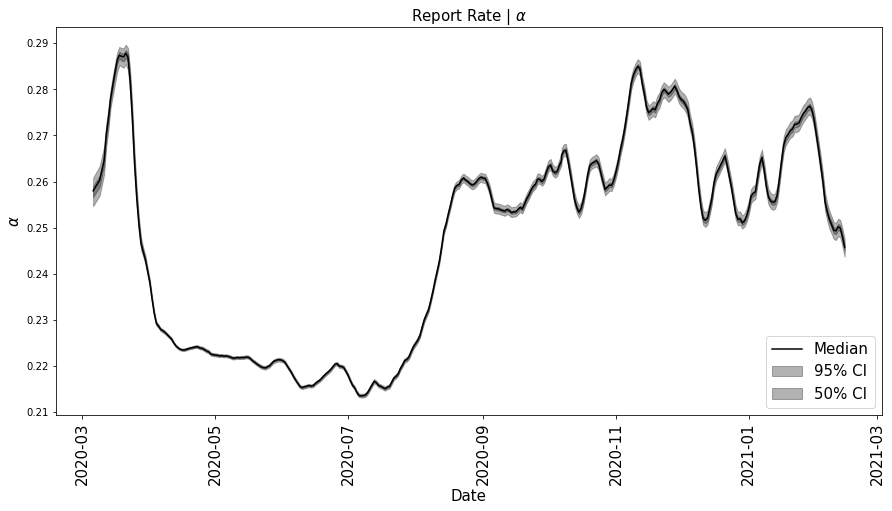

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(df_alpha.index.values, df_alpha["median"], color='k', label='Median')
ax.fill_between(df_alpha.index.values, df_alpha["high_95"], df_alpha["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_alpha.index.values, df_alpha["high_50"], df_alpha["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
# ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
# ax.tick_params( which='both', axis='both', labelsize=15)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel(r"$\alpha$", fontsize=15)
ax.set_title(r"Report Rate | $\alpha$ ", fontsize=15)
ax.legend(fontsize=15, loc='best')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Hospitalized')

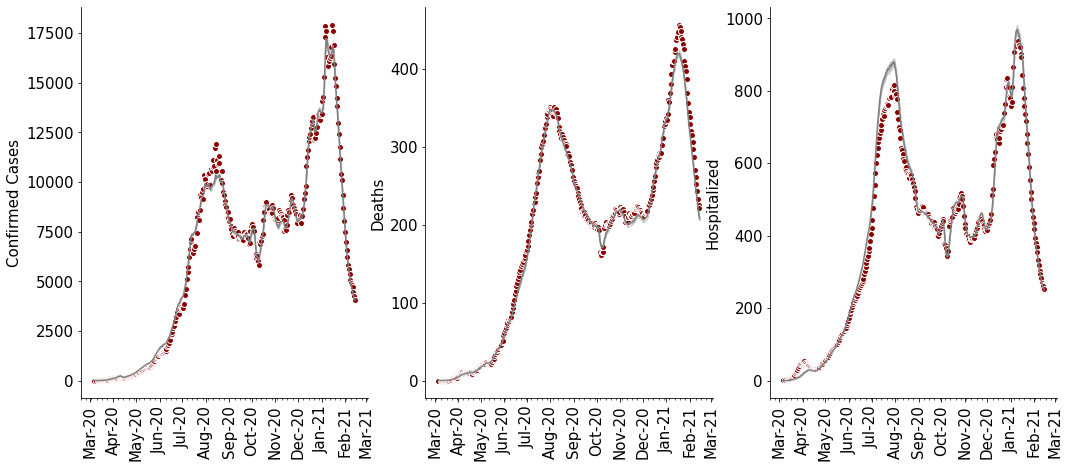

In [18]:
confirmed_post_all    = obs_post_all[0,:,:,:]
deaths_post_all       = obs_post_all[1,:,:,:]
hospitalized_post_all = obs_post_all[2,:,:,:]



take_post        = 1
df_confirmed     = create_df_response(np.take(np.squeeze(confirmed_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)
df_deaths        = create_df_response(np.take(np.squeeze(deaths_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)
df_hospitalized  = create_df_response(np.take(np.squeeze(hospitalized_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)


fig, ax = plt.subplots(1, 3, figsize=(17.5, 7.2))

ax[0].plot(df_deaths.index.values, df_confirmed["median"], color='gray', label='Median')
ax[0].fill_between(df_confirmed.index.values, df_confirmed["high_95"], df_confirmed["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[0].fill_between(df_confirmed.index.values, df_confirmed["high_50"], df_confirmed["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[0].scatter(obs_df.index.values, obs_df["smoothed_InfectadosTotal"], edgecolors="w", facecolor="darkred")

ax[1].plot(df_deaths.index.values, df_deaths["median"], color='gray', label='Median')
ax[1].fill_between(df_deaths.index.values, df_deaths["high_95"], df_deaths["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[1].fill_between(df_deaths.index.values, df_deaths["high_50"], df_deaths["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[1].scatter(obs_df.index.values, obs_df["smoothed_MuertesTotal"], edgecolors="w", facecolor="darkred")

ax[2].plot(df_hospitalized.index.values, df_hospitalized["median"], color='gray', label='Median')
ax[2].fill_between(df_hospitalized.index.values, df_hospitalized["high_95"], df_hospitalized["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[2].fill_between(df_hospitalized.index.values, df_hospitalized["high_50"], df_hospitalized["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[2].scatter(obs_df.index.values, obs_df["smoothed_HospitalizadosTotal"], edgecolors="w", facecolor="darkred")

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', rotation=90, labelsize=15)

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0].set_ylabel("Confirmed Cases", fontsize=15)
ax[1].set_ylabel("Deaths", fontsize=15)
ax[2].set_ylabel("Hospitalized", fontsize=15)

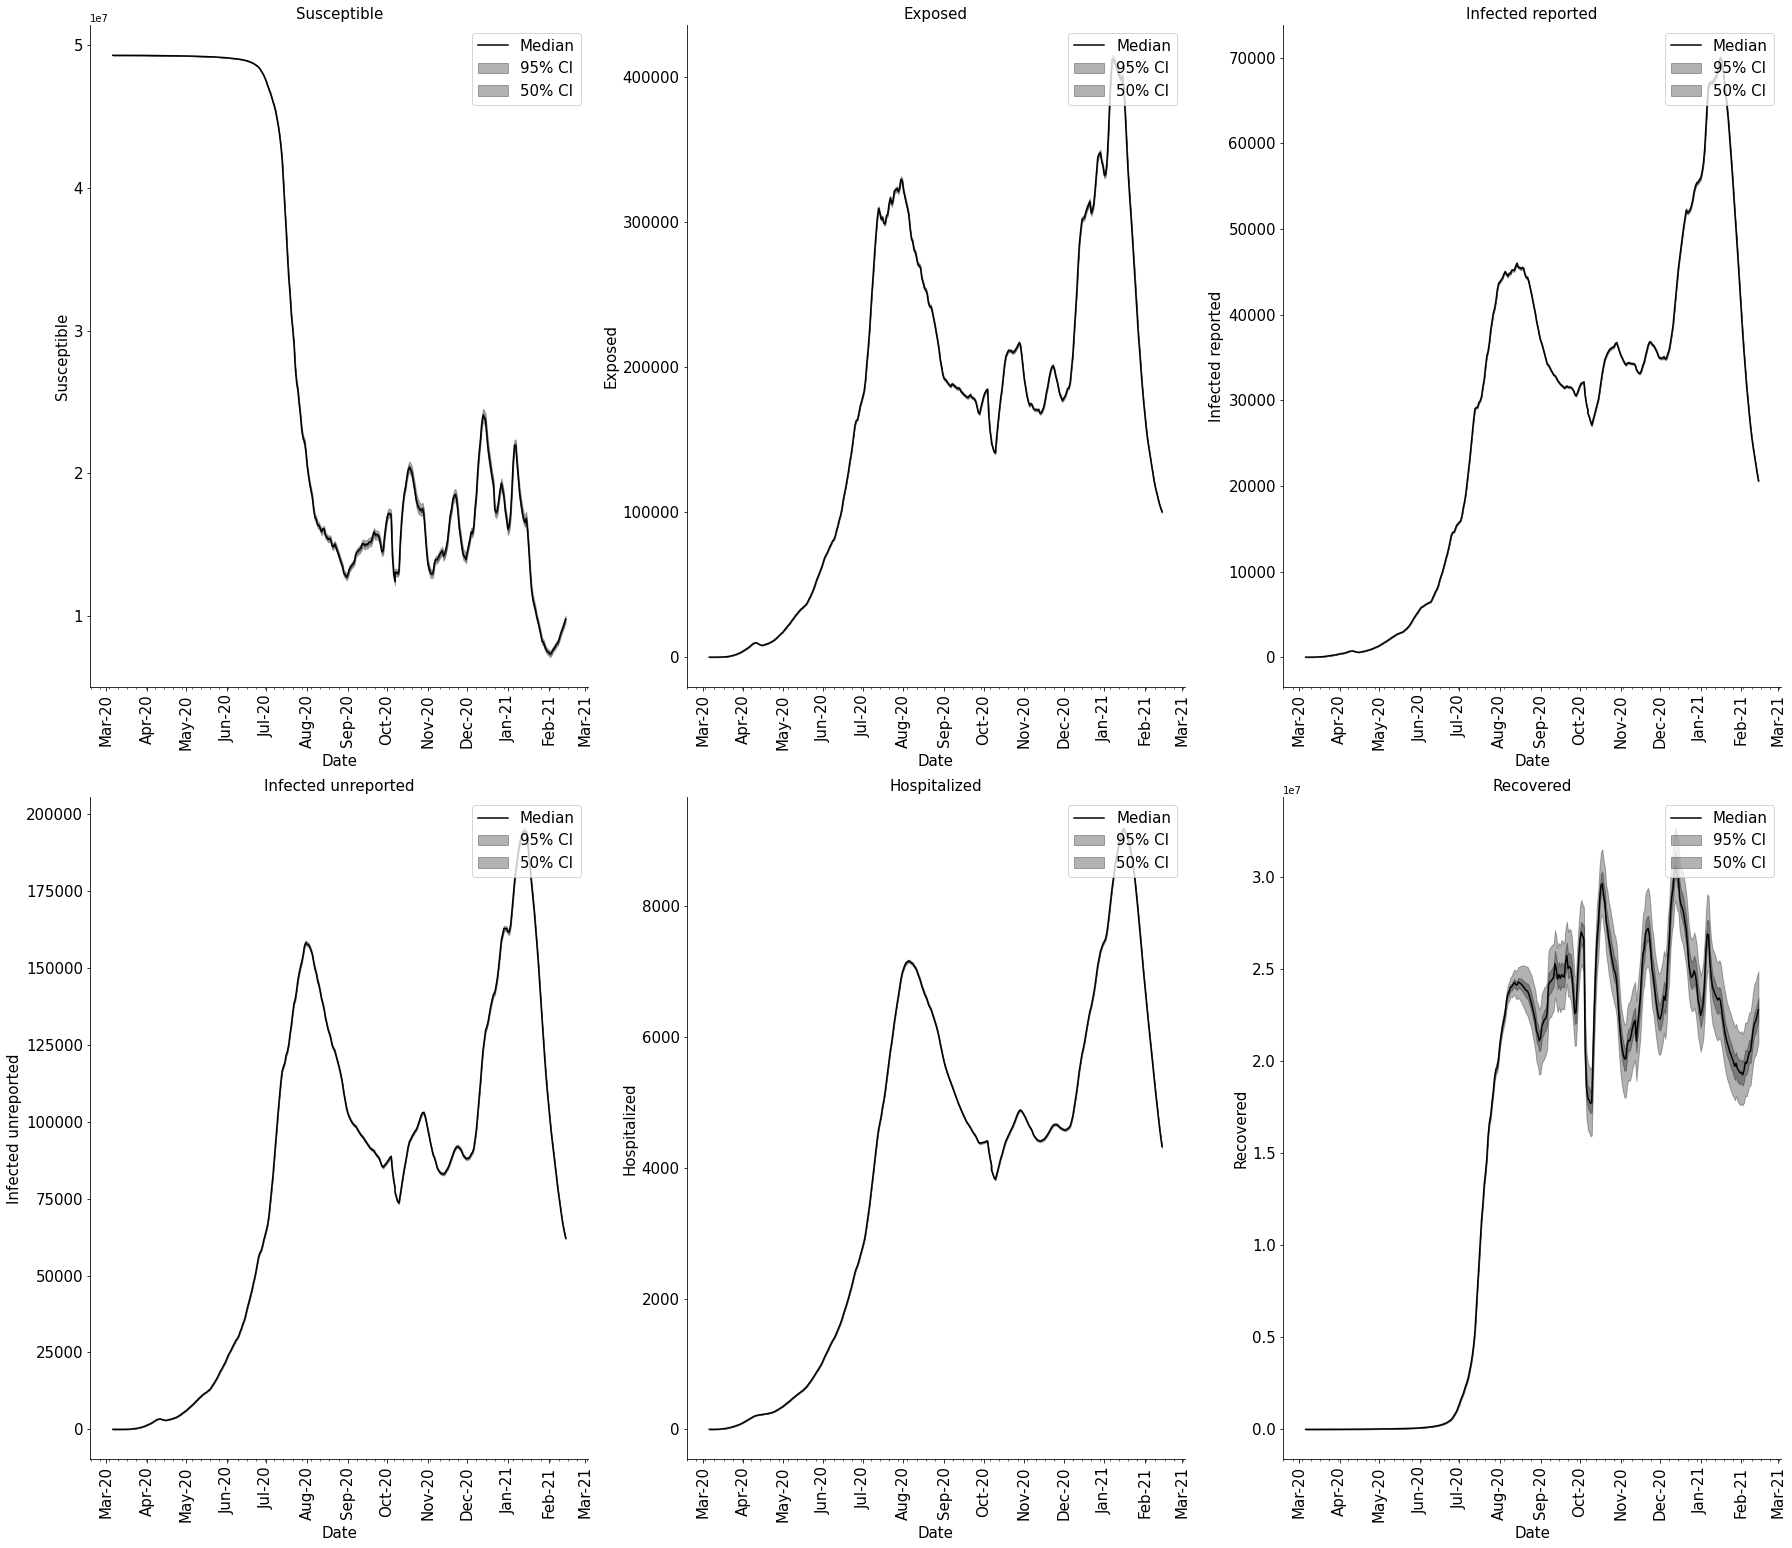

In [19]:
S_time = np.mean(x_post_all[0,:,:,:6], -1)
E_time = np.mean(x_post_all[1,:,:,:6], -1)
Ir_time = np.mean(x_post_all[2,:,:,:6], -1)
Iu_time = np.mean(x_post_all[3,:,:,:6], -1)
Ih_time = np.mean(x_post_all[4,:,:,:6], -1)
R_time = np.mean(x_post_all[5,:,:,:6], -1)
H_time = np.mean(x_post_all[6,:,:,:6], -1)
C_time = np.mean(x_post_all[7,:,:,:6], -1)
D_time = np.mean(x_post_all[8,:,:,:6], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates_assimilation)
df_E  = create_df_response(E_time, time=num_steps, dates =dates_assimilation)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates_assimilation)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates_assimilation)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates_assimilation)
df_R  = create_df_response(R_time, time=num_steps, dates =dates_assimilation)
df_H  = create_df_response(C_time, time=num_steps, dates =dates_assimilation)
df_C  = create_df_response(C_time, time=num_steps, dates =dates_assimilation)
df_D  = create_df_response(D_time, time=num_steps, dates =dates_assimilation)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Hospitalized", fontsize=15)
ax[1,1].set_title("Hospitalized", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

In [75]:
Rt_age = np.zeros((200,345))
beta_time = param_time[0,:,:]
alpha_time = param_time[1,:,:]
Rt_age =beta_time*(1-ihr)*(1/0.25)*(alpha_time+(0.5*(1-alpha_time)))


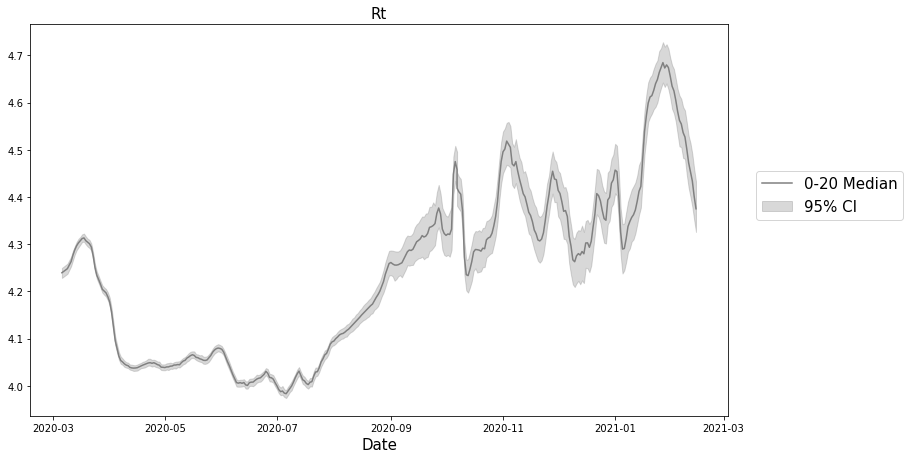

In [76]:
df_Rt0   = create_df_response(Rt_age, time=num_steps, dates =dates_assimilation)


fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(df_Rt0.index.values, df_Rt0["median"], color='gray', label='0-20 Median')
ax.fill_between(df_Rt0.index.values, df_Rt0["high_95"], df_Rt0["low_95"], color='gray', alpha=0.3, label='95% CI')

ax.set_xlabel("Date", fontsize=15)
# ax.set_ylabel(r"$\alpha$", fontsize=15)
ax.set_title("Rt", fontsize=15)
ax.legend(fontsize=15, loc=(1.04,0.5))